In [1]:
#!python
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math as math 
from scipy.optimize import curve_fit
rodcurrents = loadmat('/Users/adrianadropulic/Downloads/rodcurrents.mat')
#print(sorted(rodcurrents.keys()))
contents = rodcurrents['rodcurrents']
print(contents.shape)
x = np.linspace(-100,694,795)
x = x/100


(350, 795)


**Plotting the Raw Data**

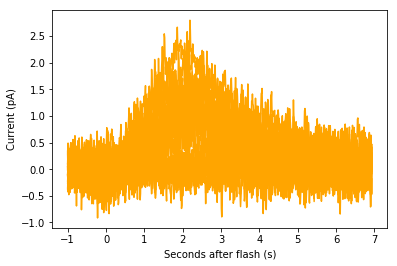

In [2]:
#Plotting the raw data
for num_flash in range(1,20):
    y = contents[num_flash,:]
    plt.plot(x,y,color = 'orange')
    plt.xlabel('Seconds after flash (s)')
    plt.ylabel('Current (pA)')
#can plot as time re flash (aka 100th bin is at 0 seconds)


**Plotting the Smoothed Current (via Convolution)**

In [3]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [4]:
print(np.ones(10)/10)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


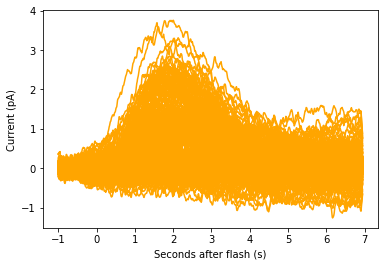

In [5]:
tpeak = []
rawcount_n1 = []
for num_flash in range(1,350):
    y = contents[num_flash,:]
    y = smooth(y,10)
    tpeak.append(np.amax(y))
    if (np.amax(y) >= 0.6) & (np.amax(y) <= 1.6): rawcount_n1.append(num_flash)
    plt.plot(x,y,color = 'orange')
    plt.xlabel('Seconds after flash (s)')
    plt.ylabel('Current (pA)')
#want to also find tpeak when the average current peaks 

The running mean is convolution. To compute the running mean, you slide a window along the input and compute the mean of the window's contents. For discrete 1D signals, convolution does essentially the same thing (instead of the mean, it computes an arbitrary linear combination i.e. multiplying each element by a coefficient and summing the results). There is one coefficient for each position in the window (coeff called the convolution kernel). The arithmetic mean of N values is (x_1 + x_2 + ... + x_N) / N, and the corresponding kernel is (1/N, 1/N, ..., 1/N), and that's what is given by using np.ones((N,))/N.

**Plotting the Smoothed Current at tpeak vs Probability Density**

In [6]:
def photon_fit(i_0, nbar, sigma0, sigma1, i_1):
    
    equation = (((nbar**0/math.factorial(0))*np.exp(- nbar)/np.sqrt(2*np.pi*(sigma0**2 + 0*sigma1**2)))* np.exp(-(i_0-0*i_1)**2/(2*(sigma0**2+0*sigma1**2))) + 
                ((nbar**1/math.factorial(1))*np.exp(- nbar)/np.sqrt(2*np.pi*(sigma0**2 + 1*sigma1**2)))* np.exp(-(i_0-1*i_1)**2/(2*(sigma0**2+1*sigma1**2))) + 
                ((nbar**2/math.factorial(2))*np.exp(- nbar)/np.sqrt(2*np.pi*(sigma0**2 + 2*sigma1**2)))* np.exp(-(i_0-2*i_1)**2/(2*(sigma0**2+2*sigma1**2))) + 
                ((nbar**3/math.factorial(3))*np.exp(- nbar)/np.sqrt(2*np.pi*(sigma0**2 + 3*sigma1**2)))* np.exp(-(i_0-3*i_1)**2/(2*(sigma0**2+3*sigma1**2))) +
                ((nbar**4/math.factorial(4))*np.exp(- nbar)/np.sqrt(2*np.pi*(sigma0**2 + 4*sigma1**2)))* np.exp(-(i_0-4*i_1)**2/(2*(sigma0**2+4*sigma1**2))))
    return equation

In [7]:
hist, bin_edges = np.histogram(tpeak, bins = np.linspace(-1,4.0,35), density=True)
bin_size = 5/35
popt_photon, pcov_photon = curve_fit(photon_fit, bin_edges[:-1],hist, sigma =(np.sqrt(hist+1)/(np.sum(hist+1)*bin_size)))
print(popt_photon)



[ 2.62365321  0.21275562 -0.27688869  0.35911922]


Text(0,0.5,'Probability density (1/pA)')

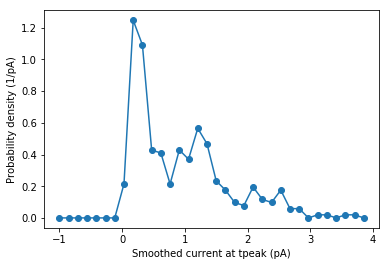

In [8]:
plt.plot(bin_edges[:-1], hist, marker = 'o')
plt.xlabel('Smoothed current at tpeak (pA)')
plt.ylabel('Probability density (1/pA)')
#plt.plot(bin_edges[:-1], photon_fit(bin_edges[:-1],popt_photon[0],popt_photon[1], popt_photon[2], popt_photon[3]))

This plot has the expected shape when compared to figure 2.4 in the textbook. 

In [9]:
#pick out single photons from histogram, avg to find one and dot with all others to make histogram s

In [10]:
#smoothed current at tpeak (0.5,1.5) corresponds to contributions fron n=1 photon events

In [11]:
#ok, so I need to find the raw current traces that correspond to these currents . means that tpeak average falls 
#in between those values 

In [12]:
sum_n1_signals = []

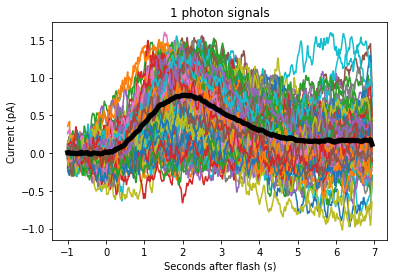

In [13]:
for num_flash_n1 in range(0,len(rawcount_n1)-1):
    y = contents[rawcount_n1[num_flash_n1],:]
    y = smooth(y,10)
    if num_flash_n1 == 0: sum_n1_signals = y
    else: sum_n1_signals = np.add(sum_n1_signals,y)
    plt.plot(x,y)
    plt.xlabel('Seconds after flash (s)')
    plt.ylabel('Current (pA)')
    plt.title('1 photon signals')
mean_n1_signal = sum_n1_signals/len(rawcount_n1)
plt.plot(x,mean_n1_signal,color = 'black',linewidth=5.0)
plt.show()

In [14]:
#now going to filter by dotting the average signal with the other signals in the original histogram, then will plot that

350


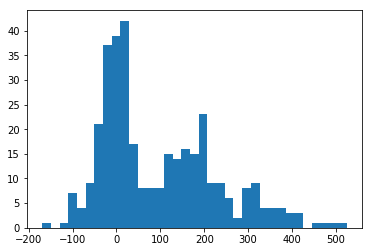

In [17]:
filtered_flashes = []
for num_flash in range(0,350):
    filtered_flashes.append(np.dot(contents[num_flash,:],mean_n1_signal))
#hist_dot, bin_edges_dot = np.histogram(filtered_flashes, bins = 35)
#plt.bar(bin_edges_dot[:-1], hist_dot)
plt.hist(filtered_flashes, bins = 35)
print(len(filtered_flashes))

In [18]:
#peak around 0 , 100, 200 Correspond to photon responses

Using the average photon response as a template attempts to reproduce the results from above. It could be better. We could do better perhaps by taking into account the photon frequency of arrivals. Bayes' theorem tells us that P(n)P(n|filter), where P(n) is the frequency of photon arrivals gives a better estimate. 